<a href="https://colab.research.google.com/github/dauparas/tensorflow_examples/blob/master/vqvae_clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VQ-VAE for clustering data

Based on 

https://arxiv.org/abs/1711.00937  
https://arxiv.org/abs/1906.00446

https://github.com/deepmind/sonnet/blob/master/sonnet/examples/vqvae_example.ipynb



In [2]:
from __future__ import print_function

import os
import subprocess
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import sonnet as snt
import tensorflow as tf
import tarfile

from six.moves import cPickle
from six.moves import urllib
from six.moves import xrange

W0625 01:49:10.254588 140283206834048 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/sonnet/python/custom_getters/restore_initializer.py:27: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0625 01:49:11.853485 140283206834048 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# Create some data

In [0]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=5000, centers=5, n_features=32,random_state=1)
data_variance = np.var(X)

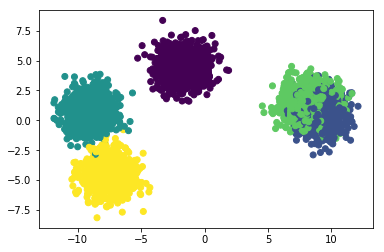

In [11]:
plt.scatter(X[:,0], X[:,1], c=y);

# Define Encoder & Decoder


In [0]:
class Encoder(snt.AbstractModule):
  def __init__(self, name='encoder'):
    super(Encoder, self).__init__(name=name)
    
  def _build(self, x):
    h = snt.Linear(16)(x)
    h = tf.nn.relu(h)
    h = snt.Linear(8)(h)
    h = tf.nn.relu(h)
    h = snt.Linear(4)(h)
    return h

class Decoder(snt.AbstractModule):
  def __init__(self, output_dim, name='decoder'):
    super(Decoder, self).__init__(name=name)
    self.output_dim = output_dim
  
  def _build(self, x):
    h = snt.Linear(8)(x)
    h = tf.nn.relu(h)
    h = snt.Linear(16)(h)
    h = tf.nn.relu(h)
    h = snt.Linear(self.output_dim)(h)
    return h

# Build Graph and train

In [13]:
tf.reset_default_graph()

# Set hyper-parameters.
batch_size = 32

num_training_updates = 5000
embedding_dim = 4
# The higher this value, the higher the capacity in the information bottleneck.
num_embeddings = 20

# commitment_cost should be set appropriately. It's often useful to try a couple
# of values. It mostly depends on the scale of the reconstruction cost
# (log p(x|z)). So if the reconstruction cost is 100x higher, the
# commitment_cost should also be multiplied with the same amount.
commitment_cost = 0.25

# Use EMA updates for the codebook (instead of the Adam optimizer).
# This typically converges faster, and makes the model less dependent on choice
# of the optimizer. In the VQ-VAE paper EMA updates were not used (but was
# developed afterwards). See Appendix of the paper for more details.
vq_use_ema = True

# This is only used for EMA updates.
decay = 0.99

learning_rate = 3e-4

# Data Loading.
train_dataset_iterator = (
    tf.data.Dataset.from_tensor_slices(X)
    .shuffle(10000)
    .repeat(-1)  # repeat indefinitely
    .batch(batch_size)).make_one_shot_iterator()
train_dataset_batch = train_dataset_iterator.get_next()

def get_samples(sess, subset='train'):
    return sess.run(train_dataset_batch)

# Build modules.
encoder = Encoder()
decoder = Decoder(X.shape[1])

if vq_use_ema:
  vq_vae = snt.nets.VectorQuantizerEMA(
      embedding_dim=embedding_dim,
      num_embeddings=num_embeddings,
      commitment_cost=commitment_cost,
      decay=decay)
else:
  vq_vae = snt.nets.VectorQuantizer(
      embedding_dim=embedding_dim,
      num_embeddings=num_embeddings,
      commitment_cost=commitment_cost)

# Process inputs with conv stack, finishing with 1x1 to get to correct size.
x = tf.placeholder(tf.float32, shape=(None, X.shape[1]))
z = encoder(x)

# For training
vq_output_train = vq_vae(z, is_training=True)
x_recon = decoder(vq_output_train["quantize"])
recon_error = tf.reduce_mean((x_recon - x)**2) / data_variance  # Normalized MSE
loss = recon_error + vq_output_train["loss"]

# For evaluation, make sure is_training=False!
vq_output_eval = vq_vae(z, is_training=False)
x_recon_eval = decoder(vq_output_eval["quantize"])

# The following is a useful value to track during training.
# It indicates how many codes are 'active' on average.
perplexity = vq_output_train["perplexity"] 

# Create optimizer and TF session.
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss)
sess = tf.train.SingularMonitoredSession()

# Train.
train_res_recon_error = []
train_res_perplexity = []
for i in xrange(num_training_updates):
  feed_dict = {x: get_samples(sess)}
  results = sess.run([train_op, recon_error, perplexity],
                     feed_dict=feed_dict)
  train_res_recon_error.append(results[1])
  train_res_perplexity.append(results[2])
  
  if (i+1) % 200 == 0:
    print('%d iterations' % (i+1))
    print('recon_error: %.3f' % np.mean(train_res_recon_error[-200:]))
    print('perplexity: %.3f' % np.mean(train_res_perplexity[-200:]))
    print()


200 iterations
recon_error: 0.995
perplexity: 6.036

400 iterations
recon_error: 0.879
perplexity: 5.862

600 iterations
recon_error: 0.659
perplexity: 5.651

800 iterations
recon_error: 0.461
perplexity: 5.412

1000 iterations
recon_error: 0.312
perplexity: 5.506

1200 iterations
recon_error: 0.228
perplexity: 5.395

1400 iterations
recon_error: 0.192
perplexity: 5.542

1600 iterations
recon_error: 0.179
perplexity: 5.557

1800 iterations
recon_error: 0.168
perplexity: 5.686

2000 iterations
recon_error: 0.167
perplexity: 5.844

2200 iterations
recon_error: 0.153
perplexity: 5.789

2400 iterations
recon_error: 0.146
perplexity: 5.546

2600 iterations
recon_error: 0.130
perplexity: 4.960

2800 iterations
recon_error: 0.106
perplexity: 4.694

3000 iterations
recon_error: 0.078
perplexity: 4.687

3200 iterations
recon_error: 0.051
perplexity: 4.701

3400 iterations
recon_error: 0.036
perplexity: 4.677

3600 iterations
recon_error: 0.030
perplexity: 4.687

3800 iterations
recon_error: 0.0

# Plot loss

Text(0.5, 1.0, 'Average codebook usage (perplexity).')

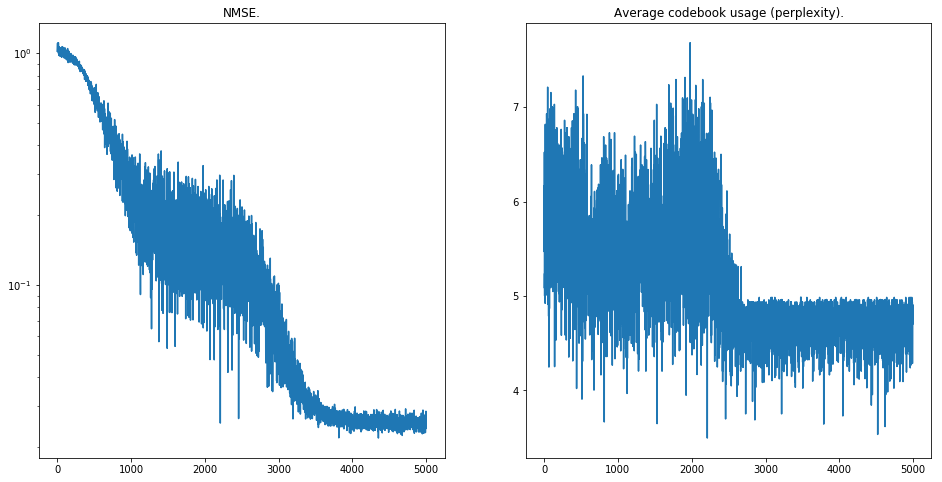

In [14]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error)
ax.set_yscale('log')
ax.set_title('NMSE.')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity)
ax.set_title('Average codebook usage (perplexity).')


# View latent space

In [0]:
# Latent space
z_, vq_output_eval_, x_recon_  = sess.run([z, vq_output_eval, x_recon], feed_dict={x: X})

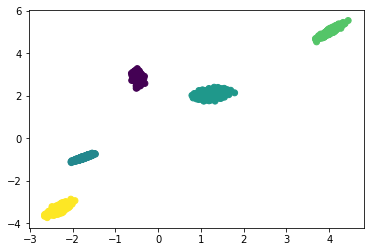

In [20]:
plt.scatter(z_[:,0], z_[:,1], c=vq_output_eval_['encoding_indices']);

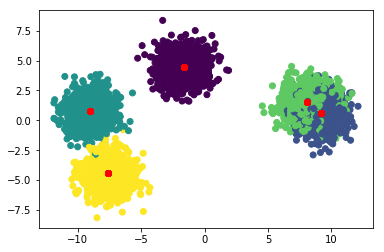

In [26]:
plt.scatter(X[:,0], X[:,1], c=y);
plt.scatter(x_recon_[:,0], x_recon_[:,1], c='red');

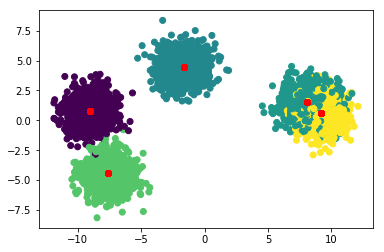

In [27]:
plt.scatter(X[:,0], X[:,1], c=vq_output_eval_['encoding_indices']);
plt.scatter(x_recon_[:,0], x_recon_[:,1], c='red');